# Symbolic regression approximation based on genetic algorithm for DFT exchange-correlation functional

В данном ноутбуке решается задача символьной регрессии для восстановления аналитического вида уравнений уже известных обменно-корреляционных функционалов LDA.

In [ ]:
!pip install -q gplearn
from gplearn.genetic import SymbolicRegressor

from sklearn.model_selection import train_test_split
from sympy import *

import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from gplearn.genetic import SymbolicTransformer
from sklearn.utils import check_random_state
from gplearn.functions import make_function

import sklearn

import matplotlib
from matplotlib import pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

Для успешной аппроксимации необходимо добавить базисные функции

In [ ]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv']

In [ ]:
def add_func(func_names, funcs):
  global function_set
  for i in range(len(funcs)):

    func_name = func_names[i]
    func = funcs[i]
    function = make_function(function=func, name=func_name, arity=1)

    function_set.append(function)

In [ ]:
def square(x):
  return x**2

def pow3(x):
  return x**3

def pow4_3(x):
  return x*np.cbrt(x)

def exp(x):
  return np.exp(x)

In [ ]:
def neg(x):
  return -x

def sub(x, y):
  return x - y

def add(x, y):
  return x+y

def inv(x):
  return 1/x

def scuare(x):
  return x**2

def div(x, y):
  return x/y

def mul(x, y):
  return x*y

In [ ]:
def cbrt(x):
  return np.cbrt(x)

add_func(['cbrt'], [cbrt])

In [ ]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

Генерация датасета Exc = f(ρ)

In [ ]:
!pip install -q pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 MB 9.3 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pyscf
import torch
torch.manual_seed(17)
import numpy as np
np.random.seed(17)
import random
random.seed(17)
from typing import Tuple, Union, List, Dict, Callable, Any
from pyscf import dft
from pyscf import gto, scf

Восстановим обменный функционал с LDA аппроксимацией

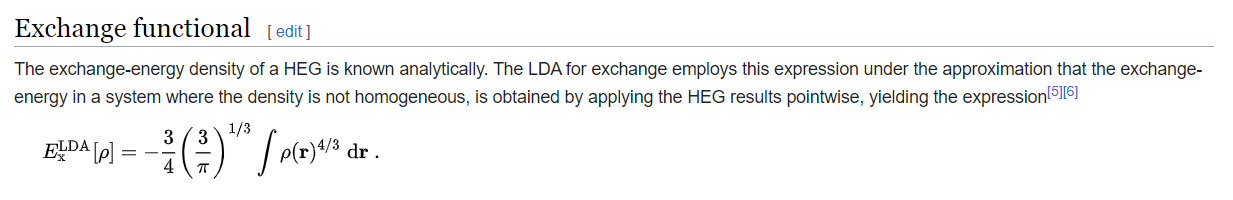

In [ ]:
#Use general data
data_train = pd.read_csv(r'/content/lda_x_first.csv')
data_test = pd.read_csv(r'/content/lda_x_test_first.csv')

rho_train, exc_train = data_train.iloc[:, 0].values, data_train.iloc[:, 1].values

rho_test, exc_test = data_test.iloc[:, 0].values, data_test.iloc[:, 1].values

Реализуем генетический алгоритм символьной регрессии

In [ ]:
est_gp = SymbolicRegressor(function_set=function_set,
                           population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9,
                           verbose=2,
                           parsimony_coefficient=0.01, random_state=0, feature_names=['rho'])
est_gp.fit(rho_train.reshape(-1, 1), exc_train)

#evaluate and see equation
print('R2:',est_gp.score(rho_test.reshape(-1, 1), exc_test))
next_e = sympify((est_gp._program), locals=converter)
next_e

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.62       2.3438e+07        5       0.00439952       0.00451152      2.61m
R2: 0.999966828567618


<ipython-input-12-8e860acaaf56>:13: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sympify(str(obj)). To add define sympify behavior on custom
objects, use sympy.core.sympify.converter or define obj._sympy_
(see the sympify() docstring).

sympify() performed the string fallback resulting in the following string:

'cbrt(neg(mul(0.402, rho)))'

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympify-string-fallback
for details.

This has been deprecated since SymPy version 1.6. It
will be removed in a future version of SymPy.

  next_e = sympify((est_gp._program), locals=converter)


0.73803226920981*(-rho)**(1/3)

In [ ]:
def approximated_func(x):
  return -0.73803226920981*(x**(1/3))

In [ ]:
rho_test = np.linspace(0, 10000000, 1000)
print(sklearn.metrics.r2_score(dft.libxc.eval_xc("lda_x", rho_test , spin=0)[0], approximated_func(rho_test)))
print((sklearn.metrics.mean_squared_error(dft.libxc.eval_xc("lda_x", rho_test , spin=0)[0], approximated_func(rho_test))**0.5))

0.9999919381325282
0.08785536052004314


In [ ]:
add_func(['scuare', 'pow3', 'pow4_3', 'exp'], [square, pow3, pow4_3, exp])

In [ ]:
def cbrt(x):
  return x**(1/3)

In [ ]:
from sympy.abc import x
from sympy import cse, sqrt, sin, pprint

In [ ]:
def see_similarity(approx_func, functional_name, train_interval, pow_high_interval):
  rho = 10**np.linspace(-6, pow_high_interval, 100000)
  exc = dft.libxc.eval_xc(functional_name, rho, spin=0)[0]
  plt.title('R2 = ' + str(sklearn.metrics.r2_score(exc, approx_func(rho)).round(3)) +
            ', MPE = ' + str((sklearn.metrics.mean_squared_error(exc, approx_func(rho))*0.5)/np.mean(dft.libxc.eval_xc('lda_c_pw_mod', train_interval, spin=0)[0])))

  ax = ([plt.plot(rho, exc, '--', color='blue'),
         plt.plot(rho, approx_func(rho), '--', color='red'),
         plt.plot(train_interval, approximated_func(train_interval),'ro', color='green')])
  plt.legend(['analitical', 'approxiamation', 'train'])
  plt.xlabel('rho')
  plt.ylabel('energy')

In [ ]:
def see_interval(approx_func, functional_name, pow_high_interval):
  rho = 10**np.linspace(-6, pow_high_interval, 100000)
  exc = dft.libxc.eval_xc(functional_name, rho, spin=0)[0]
  plt.title('RMSE = ' + str((sklearn.metrics.mean_squared_error(exc, approx_func(rho))**0.5).round(3)))

  ax = ([plt.plot(rho, exc, '--', color='blue'),
         plt.plot(rho, approx_func(rho), '--', color='red')])
  plt.legend(['approxiamation', 'analitical'])
  plt.xlabel('rho')
  plt.ylabel('energy')

In [ ]:
def make_functional(gp, rho_train, exc_train, rho_test, exc_test):
  gp_features = gp.transform(rho_train.reshape(-1, 1))
  new_X = pd.DataFrame(gp_features)
  global est
  est = Ridge(alpha=0)
  est.fit(new_X, exc_train)

  ax = ([plt.plot(est.predict(gp.transform(rho_test.reshape(-1, 1))), exc_test, 'ro'),
          plt.plot(est.predict(gp.transform(rho_train.reshape(-1, 1))), exc_train, 'ro', color='b')])
  plt.title('Test R2 = '+str(sklearn.metrics.r2_score(exc_test, est.predict(gp.transform(rho_test.reshape(-1, 1)))).round(3)))
  plt.xlabel('analitical')
  plt.ylabel('predicted')
  plt.legend(['test', 'train'])


#Восстановим корреляционные функционалы в приближении LDA
Используем линейное и экспотенциальное распределение (чтобы в конечный набор точек входило большое количество точек < 1 и >> 1) и затем сравним точность аппроксимации

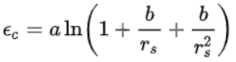 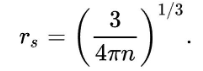

c_pw_mod linear distribution

In [ ]:
#Use general data
data_train = pd.read_csv(r'/content/lda_c_pw_mod_first.csv')
data_test = pd.read_csv(r'/content/lda_c_pw_mod_test_first.csv')

rho_train, exc_train = data_train.iloc[:, 0].values, data_train.iloc[:, 1].values

rho_test, exc_test = data_test.iloc[:, 0].values, data_test.iloc[:, 1].values

Следующая функция подбирает нелинейные преобразования над фичой

In [ ]:
gp = SymbolicTransformer(generations=2, population_size=5000,
                         hall_of_fame=20, n_components=1,
                         function_set=function_set,
                         parsimony_coefficient=0.001,
                         max_samples=0.9, verbose=1,
                         random_state=2)
gp.fit(rho_train.reshape(-1, 1), exc_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.59         0.433723        6         0.999996         0.999995     11.08s
   1     7.18         0.848812        9                1         0.999999      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv',
                                  <gplearn.functions._Function object at 0x7b77a83bdb70>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3f10>,
                                  <gplearn.functions._Function object at 0x7b76ca1b2470>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3fd0>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3430>],
                    generations=2, hall_of_fame=20, max_samples=0.9,
                    n_components=1, population_size=5000, random_state=2,
                    verbose=1)

После нелинейных преобразований составим линейную модель чтобы определить константы

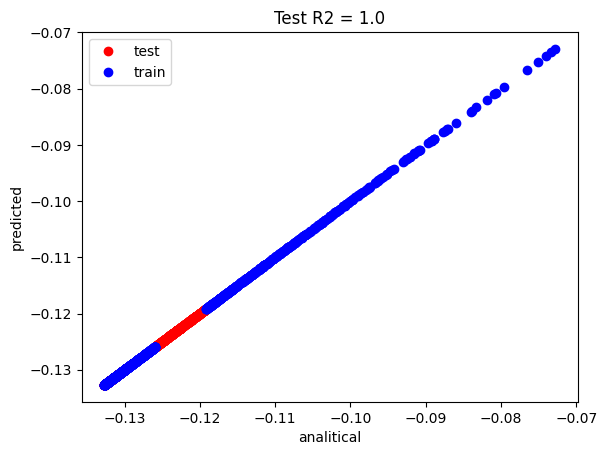

In [ ]:
make_functional(gp, rho_train, exc_train, rho_test, exc_test)

Извлечем полученный функционал из SymbolicTransformer и коэффициентов линейной регрессии



In [ ]:
#(1) c_pw_mod linear distribution
def approximated_func(x):
  return -0.0102225040280151*np.log(0.859*x+np.sqrt(x**1.333333333333333)) - 0.0647051914848863

# What does the function look like?
est.coef_[0]*log(add(sqrt(scuare(scuare(cbrt(x)))), mul(x, 0.859)))+est.intercept_


-0.0102225040280151*log(0.859*x + sqrt(x**1.33333333333333)) - 0.0647051914848863

Рассмотрим на большом диапазоне как аппроксимирующая функция накладывается на аналитическую

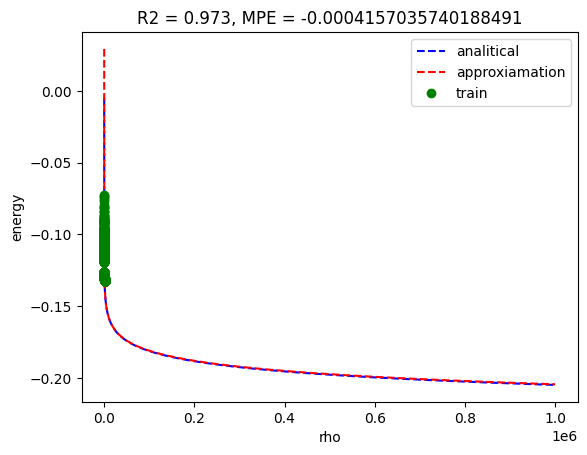

In [ ]:
see_similarity(approximated_func, 'lda_c_pw_mod', rho_train, 6)

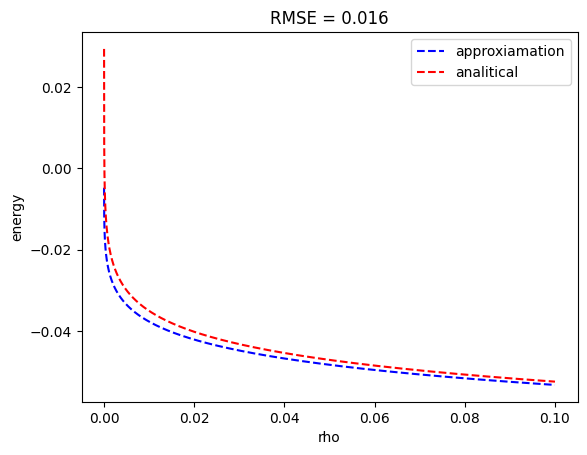

In [ ]:
see_interval(approximated_func, 'lda_c_pw_mod', -1)

c_pw_mod expotencial distribution

In [ ]:
#How data was generated?
rho_train = 10**(np.concatenate([np.random.uniform(-1, 1, 1000), np.random.uniform(3, 5, 1000)]))
exc_train = dft.libxc.eval_xc('lda_c_pw_mod', rho_train, spin=0)[0]

rho_test = 10**(np.concatenate([np.random.uniform(-3, -1, 1000), np.random.uniform(1, 3, 1000), np.random.uniform(5, 6, 1000)]))
exc_test = dft.libxc.eval_xc('lda_c_pw_mod', rho_test, spin=0)[0]


In [ ]:
#Use general data
data_train = pd.read_csv(r'/content/lda_c_pw_mod_second.csv')
data_test = pd.read_csv(r'/content/lda_c_pw_mod_test_second.csv')

rho_train, exc_train = data_train.iloc[:, 0].values, data_train.iloc[:, 1].values

rho_test, exc_test = data_test.iloc[:, 0].values, data_test.iloc[:, 1].values

In [ ]:
gp = SymbolicTransformer(generations=3, population_size=1200,
                         hall_of_fame=20, n_components=1,
                         function_set=function_set,
                         parsimony_coefficient=0.0001,
                         max_samples=0.9, verbose=1,
                         random_state=0)
gp.fit(rho_train.reshape(-1, 1), exc_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.76         0.369865        9         0.999908         0.999919      4.52s
   1     9.12         0.733911       14         0.999986         0.999984      1.77s
   2     4.69         0.850964        9         0.999997         0.999997      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv',
                                  <gplearn.functions._Function object at 0x7b77a83bdb70>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3f10>,
                                  <gplearn.functions._Function object at 0x7b76ca1b2470>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3fd0>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3430>],
                    generations=3, hall_of_fame=20, max_samples=0.9,
                    n_components=1, parsimony_coefficient=0.0001,
                    population_size=1200, random_state=0, verbose=1)

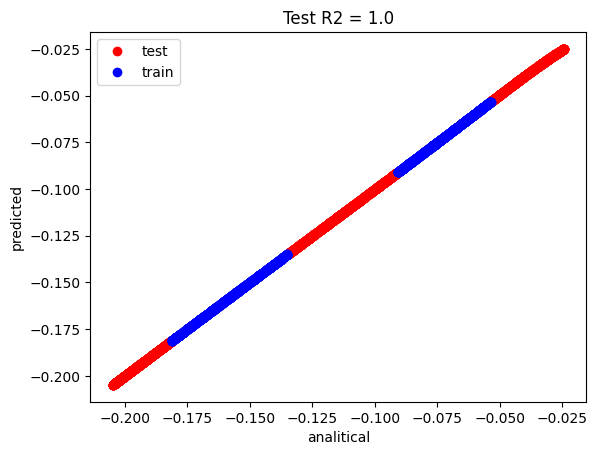

In [ ]:
make_functional(gp, rho_train, exc_train, rho_test, exc_test)

In [ ]:
#(2) c_pw_mod expotencial distribution
def approximated_func(x):
  return -0.0154165282967114*np.log(0.719840499648197*x**0.333333333333333 + x**0.666666666666) - 0.0627902387412178

# What does the function look like?
est.coef_[0]*log(add(cbrt(mul(0.373, x)), sqrt(cbrt(scuare(scuare(x))))))+est.intercept_


-0.0154165282967114*log(0.719840499648197*x**0.333333333333333 + (x**4)**0.166666666666667) - 0.0627902387412178

In [ ]:
print(sklearn.metrics.r2_score(exc_test, approximated_func(rho_test)))
print(abs((sklearn.metrics.mean_squared_error(exc_test, approximated_func(rho_test))**0.5)*100/np.mean(exc_test)), '%')
sklearn.metrics.mean_squared_error(exc_test, approximated_func(rho_test))**0.5

0.9999868950561112
0.20225845448842936 %


0.0002311887055137672

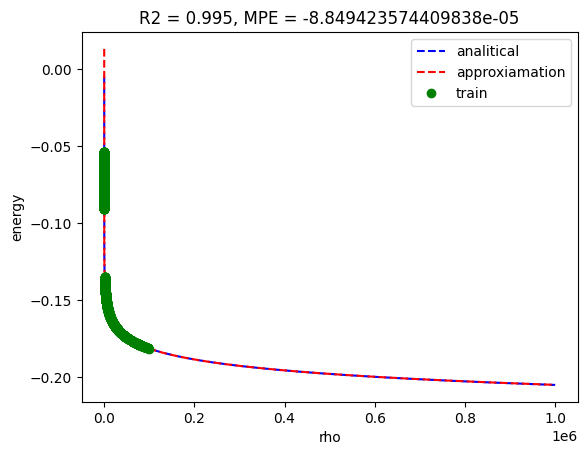

In [ ]:
see_similarity(approximated_func, 'lda_c_pw_mod', rho_train, 6)

Аппроксимация удовлитворительна на любых интервалах

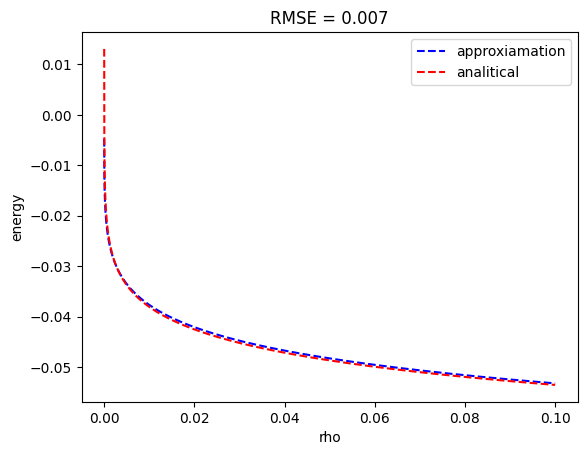

In [ ]:
see_interval(approximated_func, 'lda_c_pw_mod', -1)

Попробуем восстановить корреляционный функционал chachio

In [ ]:
#(1) Chachio functional from linear distibution
data_train = pd.read_csv(r'/content/lda_c_chachiyo_test_first.csv')
data_test = pd.read_csv(r'/content/lda_c_chachiyo_first.csv')

rho_train, exc_train = data_train.iloc[:, 0].values, data_train.iloc[:, 1].values

rho_test, exc_test = data_test.iloc[:, 0].values, data_test.iloc[:, 1].values

In [ ]:
gp = SymbolicTransformer(generations=2, population_size=1200,
                         hall_of_fame=20, n_components=1,
                         function_set=function_set,
                         parsimony_coefficient=0.001,
                         max_samples=0.9, verbose=1,
                         random_state=1)
gp.fit(rho_train.reshape(-1, 1), exc_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.49         0.510827       15                1                1      3.88s
   1     4.92         0.932286        8                1                1      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv',
                                  <gplearn.functions._Function object at 0x7b77a83bdb70>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3f10>,
                                  <gplearn.functions._Function object at 0x7b76ca1b2470>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3fd0>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3430>],
                    generations=2, hall_of_fame=20, max_samples=0.9,
                    n_components=1, population_size=1200, random_state=1,
                    verbose=1)

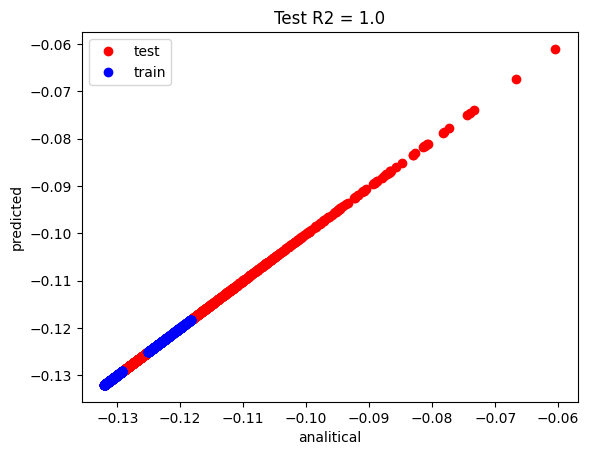

In [ ]:
make_functional(gp, rho_train, exc_train, rho_test, exc_test)

In [ ]:
#(1) Chachio functional trained on a linear distribution
def approximated_func(x):
  return -0.0218842103556609*np.log(x**(1/3)+np.sqrt(x+0.167))-0.0526936424244069

est.coef_[0]*log(add(cbrt(x), sqrt(add(x, 0.167))))+est.intercept_

-0.0218842103556609*log(x**0.333333333333333 + sqrt(x + 0.167)) - 0.0526936424244069

In [ ]:
print(sklearn.metrics.r2_score(exc_test, approximated_func(rho_test)))
print(abs((sklearn.metrics.mean_squared_error(exc_test, approximated_func(rho_test))**0.5)*100/np.mean(exc_test)), '%')
sklearn.metrics.mean_squared_error(exc_test, approximated_func(rho_test))**0.5

0.9999635846668228
0.05576741364515801 %


6.808661377445376e-05

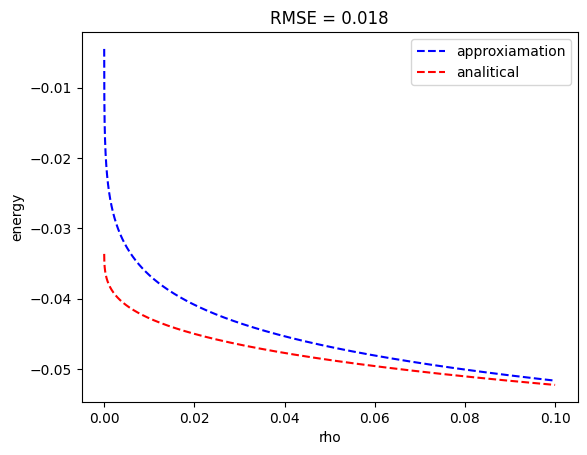

In [ ]:
see_interval(approximated_func, 'lda_c_chachiyo', -1)

In [ ]:
#(2) Chachio functional trained on a expotencial distribution
data_train = pd.read_csv(r'/content/lda_c_chachiyo_test_second.csv')
data_test = pd.read_csv(r'/content/lda_c_chachiyo_second.csv')

rho_train, exc_train = data_train.iloc[:, 0].values, data_train.iloc[:, 1].values

rho_test, exc_test = data_test.iloc[:, 0].values, data_test.iloc[:, 1].values

In [ ]:
gp = SymbolicTransformer(generations=3, population_size=5000,
                         hall_of_fame=20, n_components=1,
                         function_set=function_set,
                         parsimony_coefficient=0.0001,
                         max_samples=0.9, verbose=1,
                         random_state=0)
gp.fit(rho_train.reshape(-1, 1), exc_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.66         0.375976       21         0.999865         0.999911     17.58s
   1     8.78         0.734725       11         0.999969         0.999969      8.04s
   2     6.81         0.845148        9         0.999983         0.999983      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv',
                                  <gplearn.functions._Function object at 0x7b77a83bdb70>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3f10>,
                                  <gplearn.functions._Function object at 0x7b76ca1b2470>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3fd0>,
                                  <gplearn.functions._Function object at 0x7b76ca1b3430>],
                    generations=3, hall_of_fame=20, max_samples=0.9,
                    n_components=1, parsimony_coefficient=0.0001,
                    population_size=5000, random_state=0, verbose=1)

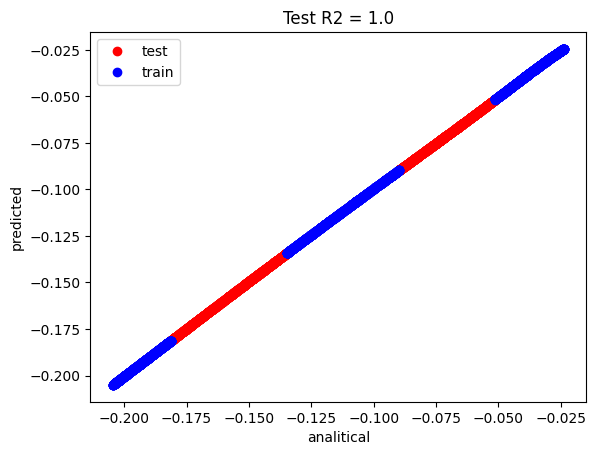

In [ ]:
make_functional(gp, rho_train, exc_train, rho_test, exc_test)

In [ ]:
#(2) Chachio functional trained on a expotencial distribution
def approximated_func(x):
  return -0.0605982412406733*np.log((x**(1/2)+2*x)**(1/6))-0.0579904439660417

est.coef_[0]*log(sqrt(cbrt(add(sqrt(x), add(x, x)))))+est.intercept_

-0.0605982412406733*log((sqrt(x) + 2*x)**0.166666666666667) - 0.0579904439660417

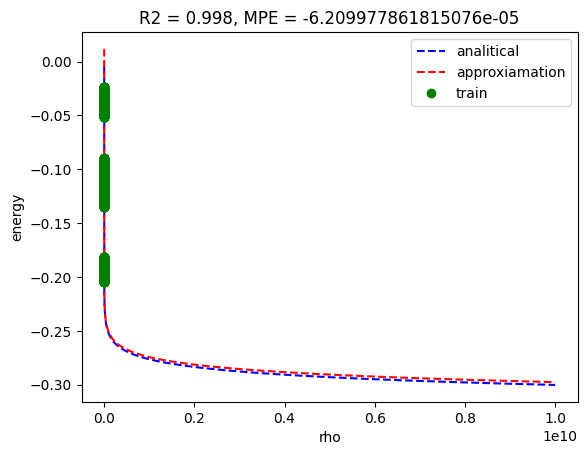

In [ ]:
see_similarity(approximated_func, 'lda_c_pw_mod', rho_train, 10)

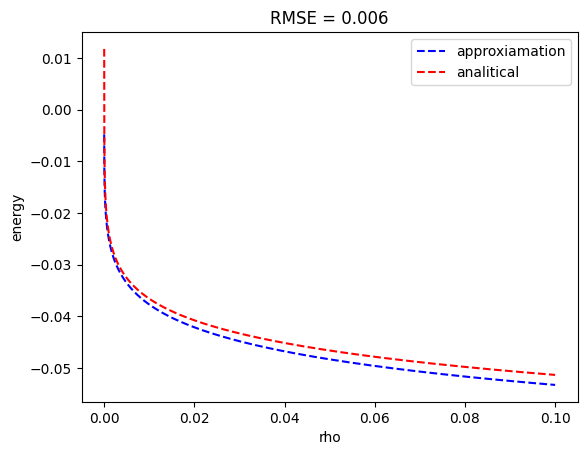

In [ ]:
see_interval(approximated_func, 'lda_c_pw_mod', -1)